In [2]:
from vnstock import Vnstock # Nạp thư viện để sử dụng
stock = Vnstock().stock(symbol='ACB', source='VCI') # Định nghĩa biến vnstock lưu thông tin mã chứng khoán & nguồn dữ liệu bạn sử dụng
# CÁC DÒNG LỆNH DƯỚI ĐÂY CÓ THỂ THAY THẾ CHO PHÙ HỢP, THAM KHẢO THÊM HÀM KHÁC
df = stock.quote.history(start='2000-01-01', end='2024-06-21', interval='1D') # Thiết lập thời gian tải dữ liệu và khung thời gian tra cứu là 1 ngày
print(df.head()) # Hiển thị 5 dòng dữ liệu đầu tiên
df.to_csv('gia_lich_su_ohlcv_ACB.csv', index=False) # Lưu file Excel

        time  open  high   low  close  volume
0 2006-11-21  4.62  5.78  4.58   5.20   56500
1 2006-11-22  5.52  5.52  5.01   5.20   62300
2 2006-11-23  5.58  5.58  5.01   5.51   69900
3 2006-11-24  5.39  5.85  5.39   5.78   63600
4 2006-11-27  5.65  6.22  5.20   5.47   42400


✅ RMSE trên tập test: 6.2043


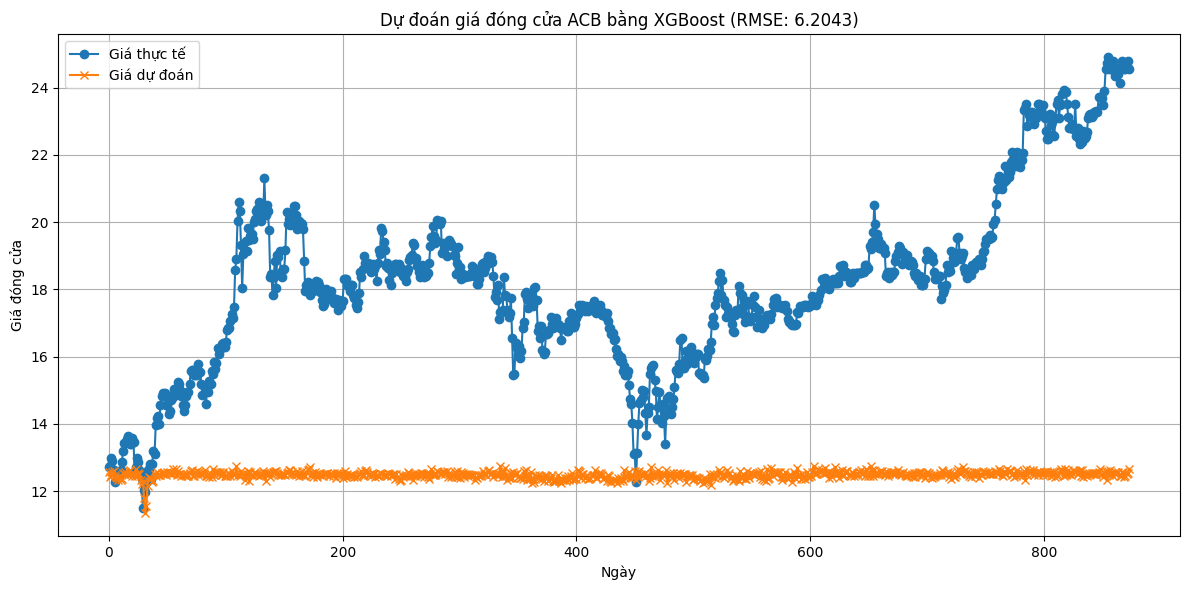


🎯 Dự đoán giá đóng cửa ACB ngày tiếp theo: 12.66 VND


In [3]:
# ======= BƯỚC 1: IMPORT THƯ VIỆN =======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# # ======= BƯỚC 2: ĐỌC FILE CSV =======
# df = pd.read_csv("gia_lich_su_ohlcv_ACB.csv")

# ======= BƯỚC 3: TẠO FEATURES =======
df['volatility'] = df['high'] - df['low']                         # Biên độ dao động
df['return_1d'] = df['close'].pct_change()                        # Tỷ lệ thay đổi giá
df['ma5'] = df['close'].rolling(window=5).mean()                  # Trung bình 5 phiên
df['ma10'] = df['close'].rolling(window=10).mean()                # Trung bình 10 phiên
df['volume_ma5'] = df['volume'].rolling(window=5).mean()
df['volume_ratio'] = df['volume'] / df['volume_ma5']              # Thanh khoản tương đối

# ======= BƯỚC 4: TẠO TARGET =======
df['target'] = df['close'].shift(-1)                              # Giá đóng cửa ngày hôm sau

# ======= BƯỚC 5: XỬ LÝ DỮ LIỆU MẤT (NaN) =======
df.dropna(inplace=True)

# ======= BƯỚC 6: TÁCH DỮ LIỆU HUẤN LUYỆN =======
features = ['open', 'high', 'low', 'close', 'volume', 'volatility', 
            'return_1d', 'ma5', 'ma10', 'volume_ratio']

X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# ======= BƯỚC 7: HUẤN LUYỆN MÔ HÌNH XGBOOST =======
model = xgb.XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)

# ======= BƯỚC 8: DỰ ĐOÁN & ĐÁNH GIÁ =======
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"✅ RMSE trên tập test: {rmse:.4f}")

# ======= BƯỚC 9: VẼ BIỂU ĐỒ GIÁ DỰ ĐOÁN VS THỰC TẾ =======
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Giá thực tế', marker='o')
plt.plot(y_pred, label='Giá dự đoán', marker='x')
plt.title(f'Dự đoán giá đóng cửa ACB bằng XGBoost (RMSE: {rmse:.4f})')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ======= BƯỚC 10: DỰ ĐOÁN GIÁ NGÀY TIẾP THEO =======
latest = df.iloc[-1:].copy()
X_future = latest[features]
predicted_price_tomorrow = model.predict(X_future)[0]

print(f"\n🎯 Dự đoán giá đóng cửa ACB ngày tiếp theo: {predicted_price_tomorrow:.2f} VND")


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ RMSE trên tập test: 0.7874


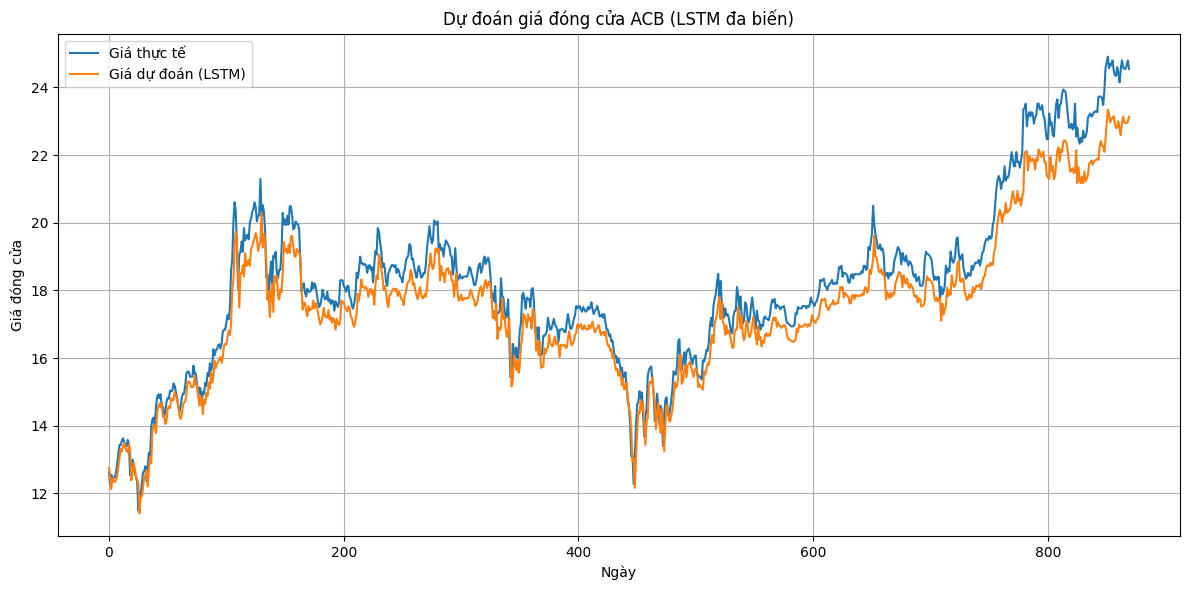

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🎯 Dự đoán giá đóng cửa ACB ngày tiếp theo (LSTM): 22.92 VND


In [4]:
# ===== 1. IMPORT THƯ VIỆN =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ===== 2. ĐỌC DỮ LIỆU =====
df = pd.read_csv("gia_lich_su_ohlcv_ACB.csv")
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# ===== 3. CHUẨN HÓA NHIỀU CỘT =====
features = ['close', 'volume', 'high', 'low']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# ===== 4. TẠO DỮ LIỆU LSTM (đa biến) =====
def create_dataset(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])  # Dự đoán 'close'
    return np.array(X), np.array(y)

window_size = 30
X, y = create_dataset(scaled_data, window_size)

# ===== 5. CHIA TRAIN/TEST =====
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ===== 6. XÂY MÔ HÌNH LSTM =====
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# ===== 7. DỰ ĐOÁN & TÍNH RMSE =====
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((len(y_pred), len(features)-1))], axis=1)
)[:, 0]
y_test_inv = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features)-1))], axis=1)
)[:, 0]

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"✅ RMSE trên tập test: {rmse:.4f}")

# ===== 8. VẼ BIỂU ĐỒ =====
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Giá thực tế')
plt.plot(y_pred_inv, label='Giá dự đoán (LSTM)')
plt.title("Dự đoán giá đóng cửa ACB (LSTM đa biến)")
plt.xlabel("Ngày")
plt.ylabel("Giá đóng cửa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 9. DỰ ĐOÁN GIÁ NGÀY MAI =====
last_seq = scaled_data[-window_size:]
last_seq = last_seq.reshape((1, window_size, len(features)))
next_day_scaled = model.predict(last_seq)
next_day_full = np.concatenate([next_day_scaled, np.zeros((1, len(features)-1))], axis=1)
next_day_price = scaler.inverse_transform(next_day_full)[0][0]

print(f"\n🎯 Dự đoán giá đóng cửa ACB ngày tiếp theo (LSTM): {next_day_price:.2f} VND")
